In [2]:
# Cell 1 — Setup & Imports
import os
import sys
from pathlib import Path

# Find project root by walking up to pyproject.toml
PROJECT_ROOT = Path.cwd()
while not (PROJECT_ROOT / "pyproject.toml").exists():
    if PROJECT_ROOT == PROJECT_ROOT.parent:
        raise RuntimeError("Could not find project root (pyproject.toml)")
    PROJECT_ROOT = PROJECT_ROOT.parent
os.chdir(PROJECT_ROOT)

# Add scripts/ to sys.path so bare imports like `from phase1.db import ...` work
scripts_path = str(PROJECT_ROOT / "scripts")
if scripts_path not in sys.path:
    sys.path.insert(0, scripts_path)

from phase1.build_memories import build_memories
from phase1.db import (
    rebuild_database,
    search_memories,
    get_memory_count,
    get_random_sample_memories,
    DEFAULT_DB_PATH,
)
from phase1.experiment import (
    run_experiment,
    run_all_experiments,
    DEFAULT_TEST_CASES_DIR,
    DEFAULT_RESULTS_DIR,
)
from common.test_cases import build_test_cases
from common.io import load_json

# Verify API key
if not os.environ.get("OPENROUTER_API_KEY"):
    print("WARNING: OPENROUTER_API_KEY is not set. Memory building and experiments will fail.")
else:
    print("OPENROUTER_API_KEY is set.")

print(f"Project root: {PROJECT_ROOT}")
print("Imports OK.")

OPENROUTER_API_KEY is set.
Project root: /Users/mayk/Projects/private/crm-memory-retrieval-research
Imports OK.


In [4]:
# Cell 2 — Configuration
PROMPT_VERSION = "2.0.0"                        # semantic versioning
MODEL_MEMORIES = "anthropic/claude-haiku-4.5"   # LLM for memory extraction
MODEL_EXPERIMENT = "anthropic/claude-sonnet-4.5" # LLM for query generation

RAW_DATA_DIR = "data/review_data"
MEMORIES_DIR = "data/phase1/memories"
DB_PATH = "data/phase1/memories/memories.db"
TEST_CASES_DIR = "data/phase1/test_cases"
RESULTS_DIR = "data/phase1/results"

print("Configuration:")
print(f"  Prompt version: {PROMPT_VERSION}")
print(f"  Model (memories): {MODEL_MEMORIES}")
print(f"  Model (experiment): {MODEL_EXPERIMENT}")
print(f"  Raw data dir: {RAW_DATA_DIR}")
print(f"  Memories dir: {MEMORIES_DIR}")
print(f"  DB path: {DB_PATH}")
print(f"  Test cases dir: {TEST_CASES_DIR}")
print(f"  Results dir: {RESULTS_DIR}")

Configuration:
  Prompt version: 2.0.0
  Model (memories): anthropic/claude-haiku-4.5
  Model (experiment): anthropic/claude-sonnet-4.5
  Raw data dir: data/review_data
  Memories dir: data/phase1/memories
  DB path: data/phase1/memories/memories.db
  Test cases dir: data/phase1/test_cases
  Results dir: data/phase1/results


## Step 1 — Build Memories

Extracts structured memories from raw code review data via LLM.
Each memory contains a **situation description** (25-60 words describing the code pattern/issue) and an **actionable lesson** (imperative guidance, max 160 chars).

Requires `OPENROUTER_API_KEY`.

In [8]:
# Cell 4 — Build Memories: Single File
raw_data_path = Path(RAW_DATA_DIR)
raw_files = sorted(raw_data_path.glob("*.json"))

print(f"Found {len(raw_files)} raw data files:")
for i, f in enumerate(raw_files):
    print(f"  [{i}] {f.name}")

if raw_files:
    # Process the first file (change index to pick a different one)
    target_file = raw_files[0]
    print(f"\nProcessing: {target_file.name}")
    output_path = build_memories(
        raw_path=str(target_file),
        out_dir=MEMORIES_DIR,
        model=MODEL_MEMORIES,
        prompt_version=PROMPT_VERSION,
    )
    print(f"Output saved to: {output_path}")
else:
    print("No raw data files found.")

Found 0 raw data files:
No raw data files found.


In [6]:
# Cell 5 — Build Memories: All Files
raw_data_path = Path(RAW_DATA_DIR)
raw_files = sorted(raw_data_path.glob("*.json"))

print(f"Processing all {len(raw_files)} raw data files...\n")

results = []
for f in raw_files:
    print(f"Processing: {f.name}")
    try:
        output_path = build_memories(
            raw_path=str(f),
            out_dir=MEMORIES_DIR,
            model=MODEL_MEMORIES,
            prompt_version=PROMPT_VERSION,
        )
        results.append({"file": f.name, "output": output_path, "status": "ok"})
    except Exception as e:
        results.append({"file": f.name, "output": None, "status": str(e)})
        print(f"  ERROR: {e}")

print(f"\nSummary: {sum(1 for r in results if r['status'] == 'ok')}/{len(results)} files processed successfully.")

Processing all 11 raw data files...

Processing: review_1.json
Memories written: 3 -> data/phase1/memories/memories_review_1_20260202_180212.jsonl
Rejected: 1 -> data/phase1/memories/rejected_review_1_20260202_180212.jsonl
Processing: review_10.json
Memories written: 5 -> data/phase1/memories/memories_review_10_20260202_180227.jsonl
Rejected: 0 -> data/phase1/memories/rejected_review_10_20260202_180227.jsonl
Processing: review_11.json
Memories written: 4 -> data/phase1/memories/memories_review_11_20260202_180249.jsonl
Rejected: 0 -> data/phase1/memories/rejected_review_11_20260202_180249.jsonl
Processing: review_2.json
Memories written: 2 -> data/phase1/memories/memories_review_2_20260202_180309.jsonl
Rejected: 3 -> data/phase1/memories/rejected_review_2_20260202_180309.jsonl
Processing: review_3.json
Memories written: 2 -> data/phase1/memories/memories_review_3_20260202_180319.jsonl
Rejected: 4 -> data/phase1/memories/rejected_review_3_20260202_180319.jsonl
Processing: review_4.json
M

## Step 2 — Create Database

Builds a SQLite database with **sqlite-vec** for vector similarity search.
Loads all accepted memories from JSONL files and indexes their situation descriptions as 1024-dimensional embeddings (via Ollama `mxbai-embed-large`).

Requires Ollama running locally with the `mxbai-embed-large` model.

In [7]:
# Cell 7 — Rebuild Database
print("Rebuilding database...")
rebuild_database(db_path=DB_PATH, memories_dir=MEMORIES_DIR)

count = get_memory_count(DB_PATH)
print(f"Database rebuilt. Total memories indexed: {count}")

Rebuilding database...
Creating database at data/phase1/memories/memories.db...
Loading memories from data/phase1/memories...
Found 41 memories
Inserting memories (generating embeddings via Ollama)...
  [1/41] Embedding mem_47f0c280ca8f...
  [2/41] Embedding mem_52c300d9d6dc...
  [3/41] Embedding mem_f29050903e92...
  [4/41] Embedding mem_56746712ed52...
  [5/41] Embedding mem_b4ad4ce6e957...
  [6/41] Embedding mem_d14ca46cce40...
  [7/41] Embedding mem_8df897f58579...
  [8/41] Embedding mem_819630bee3db...
  [9/41] Embedding mem_b09708770b0e...
  [10/41] Embedding mem_638ce08683ad...
  [11/41] Embedding mem_2d01622ee7e8...
  [12/41] Embedding mem_ddb0fa4f5e2c...
  [13/41] Embedding mem_bd7e14fb86d7...
  [14/41] Embedding mem_13c005e3e7f9...
  [15/41] Embedding mem_7847dca3ec16...
  [16/41] Embedding mem_5158e1038395...
  [17/41] Embedding mem_6f362f1d6808...
  [18/41] Embedding mem_eac383ab5d1a...
  [19/41] Embedding mem_716ae57343ef...
  [20/41] Embedding mem_c2acc67695b5...
  [21/41

In [8]:
# Cell 8 — Verify Database: Sample Search
sample_query = "error handling in async functions"
print(f"Sample search: \"{sample_query}\"\n")

results = search_memories(db_path=DB_PATH, query=sample_query, limit=5)

if results:
    for i, r in enumerate(results):
        print(f"--- Result {i + 1} (distance: {r.get('distance', 'N/A'):.4f}) ---")
        print(f"  ID: {r.get('id', 'N/A')}")
        print(f"  Situation: {r.get('situation_description', 'N/A')}")
        print(f"  Lesson: {r.get('lesson', 'N/A')}")
        print()
else:
    print("No results found. Check that the database is populated and Ollama is running.")

Sample search: "error handling in async functions"

--- Result 1 (distance: 0.7539) ---
  ID: mem_d595320d70d3
  Situation: Form submission handler with try-catch error handling. Error state persists across retries; missing `setError(null)` at operation start, causing stale error messages to display after successful subsequent attempts.
  Lesson: Clear error state at the start of async operations to prevent stale errors from persisting after successful retries.

--- Result 2 (distance: 0.8491) ---
  ID: mem_3ee4e60637bc
  Situation: Service method executing async database insert within loop. Missing `await` on `db.execute()` call for revoked token insertion; synchronous execution blocks async flow while commit awaits properly.
  Lesson: Always await async function calls in loops; missing await silently creates unawaited coroutines that never execute.

--- Result 3 (distance: 0.8565) ---
  ID: mem_9c08b6b6a581
  Situation: Exception filter catching specific exception type with optional 

## Step 3 — Create Test Cases

Matches raw PR data to extracted memories to build **ground truth** test cases.
Each test case contains the filtered diff, PR context, and the set of memory IDs that should be retrieved.
PRs with no matching memories are skipped.

In [9]:
# Cell 10 — Build Test Cases
print("Building test cases...\n")
build_test_cases(
    raw_dir=RAW_DATA_DIR,
    memories_dir=MEMORIES_DIR,
    output_dir=TEST_CASES_DIR,
)

test_case_files = sorted(Path(TEST_CASES_DIR).glob("*.json"))
print(f"\nGenerated {len(test_case_files)} test cases:")
for f in test_case_files:
    tc = load_json(str(f))
    gt_count = tc.get("ground_truth_count", len(tc.get("ground_truth_memory_ids", [])))
    print(f"  {f.name} — {gt_count} ground truth memories")

Building test cases...

Loading all memories...
Loaded 41 memories
[1/11] Processing review_1.json...
  Created test case with 3 ground truth memories
[2/11] Processing review_10.json...
  Created test case with 5 ground truth memories
[3/11] Processing review_11.json...
  Created test case with 4 ground truth memories
[4/11] Processing review_2.json...
  Created test case with 2 ground truth memories
[5/11] Processing review_3.json...
  Created test case with 2 ground truth memories
[6/11] Processing review_4.json...
  Created test case with 3 ground truth memories
[7/11] Processing review_5.json...
  Created test case with 5 ground truth memories
[8/11] Processing review_6.json...
  Created test case with 4 ground truth memories
[9/11] Processing review_7.json...
  Created test case with 4 ground truth memories
[10/11] Processing review_8.json...
  Created test case with 5 ground truth memories
[11/11] Processing review_9.json...
  Created test case with 4 ground truth memories

TEST

## Step 4 — Run Experiments

For each test case, the experiment:
1. Generates search queries from the PR context and diff via LLM
2. Runs vector similarity search against the database
3. Computes **recall**, **precision**, and **F1** against the ground truth

Requires both `OPENROUTER_API_KEY` and Ollama with `mxbai-embed-large`.

In [ ]:
# Cell 12 — Run Single Experiment
test_case_files = sorted(Path(TEST_CASES_DIR).glob("*.json"))

if test_case_files:
    target = test_case_files[0]
    print(f"Running experiment on: {target.name}\n")

    result = run_experiment(
        test_case_path=str(target),
        db_path=DB_PATH,
        model=MODEL_EXPERIMENT,
        results_dir=RESULTS_DIR,
        prompt_version=PROMPT_VERSION,
    )

    metrics = result.get("metrics", {})
    gt = result.get("ground_truth", {})
    print(f"Recall:    {metrics.get('recall', 'N/A')}")
    print(f"Precision: {metrics.get('precision', 'N/A')}")
    print(f"F1:        {metrics.get('f1', 'N/A')}")
    print(f"\nQueries generated: {metrics.get('total_queries', 'N/A')}")
    print(f"Unique memories retrieved: {metrics.get('total_unique_retrieved', 'N/A')}")
    print(f"Within threshold: {metrics.get('total_within_threshold', 'N/A')}")
    print(f"Ground truth count: {gt.get('count', 'N/A')}")
    print(f"Ground truth retrieved: {metrics.get('ground_truth_retrieved', 'N/A')}")
else:
    print("No test cases found. Run Step 3 first.")

In [10]:
# Cell 13 — Run All Experiments
print("Running all experiments...\n")

all_results = run_all_experiments(
    test_cases_dir=TEST_CASES_DIR,
    db_path=DB_PATH,
    model=MODEL_EXPERIMENT,
    results_dir=RESULTS_DIR,
    prompt_version=PROMPT_VERSION,
)

print(f"\nCompleted {len(all_results)} experiments.\n")
print(f"{'Test Case':<40} {'Recall':>8} {'Precision':>10} {'F1':>8}")
print("-" * 70)
for r in all_results:
    name = r.get("test_case_id", "?")[:40]
    m = r.get("metrics", {})
    print(f"{name:<40} {m.get('recall', 0):>8.3f} {m.get('precision', 0):>10.3f} {m.get('f1', 0):>8.3f}")

if all_results:
    metrics_list = [r.get("metrics", {}) for r in all_results]
    avg_recall = sum(m.get("recall", 0) for m in metrics_list) / len(metrics_list)
    avg_precision = sum(m.get("precision", 0) for m in metrics_list) / len(metrics_list)
    avg_f1 = sum(m.get("f1", 0) for m in metrics_list) / len(metrics_list)
    print("-" * 70)
    print(f"{'AVERAGE':<40} {avg_recall:>8.3f} {avg_precision:>10.3f} {avg_f1:>8.3f}")

Running all experiments...


[1/11] Processing review_1.json
Test case: tc_review_1
Diff stats: 18569 -> 18569 chars
Ground truth memories: 3
Using prompt memory-query/v2.0.0 with 5 sample memories
Generating queries via anthropic/claude-sonnet-4.5...
Generated 9 queries

EXPERIMENT RESULTS: tc_review_1
Source: review_1.json
PR: bugfix/VAPI-766 -> release/v1.32.1
Model: anthropic/claude-sonnet-4.5
Prompt version: memory-query/v2.0.0
Queries generated: 9
Avg query length: 32.0 words
Ground truth memories: 3
Retrieved (unique, all): 36
Retrieved (within threshold 1.1): 36
Ground truth retrieved: 3

METRICS (threshold=1.1):
  Recall:    100.0%
  Precision: 8.3%
  F1 Score:  0.154
  Query hit rate: 100.0%

Results saved to: data/phase1/results/results_tc_review_1_exp_20260202_180652.json

[2/11] Processing review_10.json
Test case: tc_review_10
Diff stats: 5475 -> 5475 chars
Ground truth memories: 5
Using prompt memory-query/v2.0.0 with 5 sample memories
Generating queries via anthropic/cl

Top@K Results (averaged over 11 test cases)

   K  Precision   Recall       F1      MRR
------------------------------------------
   1      0.909    0.252    0.388    0.909
   2      0.864    0.458    0.589    0.909
   3      0.758    0.615    0.666    0.909
   5      0.636    0.847    0.713    0.932
  10      0.336    0.888    0.481    0.932
  15      0.236    0.952    0.374    0.932
  20      0.177    0.952    0.296    0.932


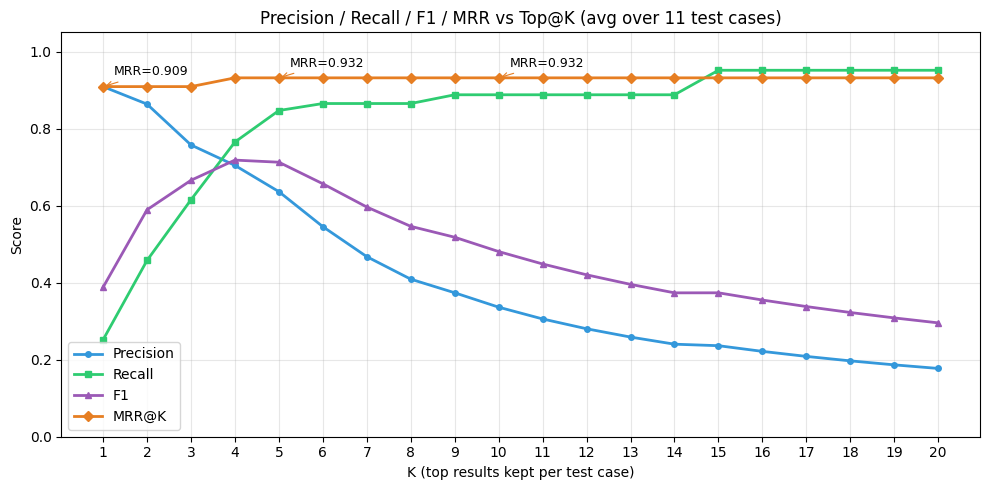


Distance Threshold Results (averaged over 11 test cases)

 Threshold  Precision   Recall       F1      MRR
------------------------------------------------
      0.65      0.879    0.562    0.667    0.909
      0.70      0.879    0.598    0.689    0.909
      0.75      0.841    0.639    0.699    0.909
      0.80      0.567    0.779    0.638    0.909
      0.85      0.409    0.888    0.533    0.932
      0.90      0.206    0.952    0.333    0.932
      0.95      0.133    0.982    0.232    0.932
      1.00      0.111    1.000    0.198    0.932
      1.10      0.103    1.000    0.186    0.932


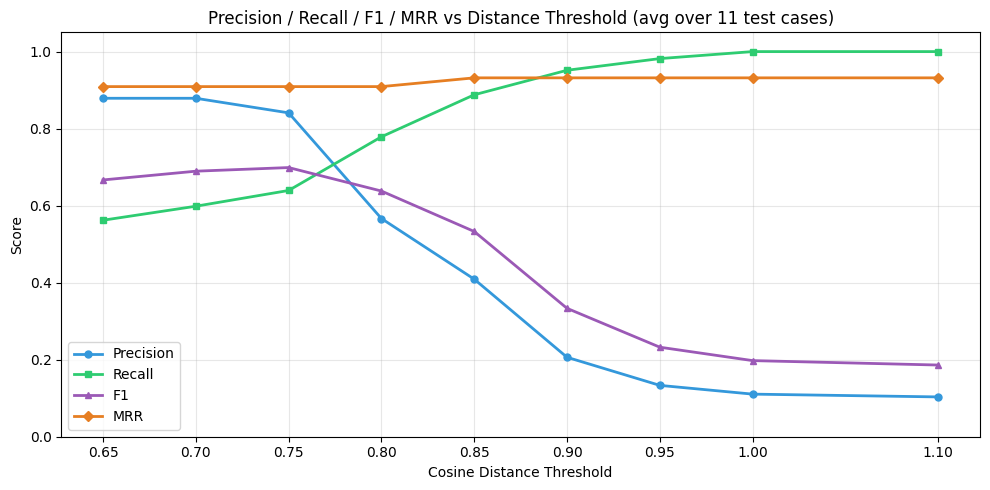

In [5]:
# Cell 14 — Results Analysis: Top@K & Distance Threshold Sweep (with MRR)
import matplotlib.pyplot as plt
import numpy as np

# === Configuration ===
DISTANCE_THRESHOLDS = [0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95, 1.00, 1.10]
MAX_K = 20

results_path = Path(RESULTS_DIR)
result_files = sorted(results_path.glob("*.json"))

if not result_files:
    print("No result files found. Run experiments first.")
else:
    all_data = [load_json(str(f)) for f in result_files]
    n_cases = len(all_data)

    # --- Helper: deduplicate results per test case (best distance per memory) ---
    def get_best_distances(data):
        best = {}
        for qr in data.get("queries", []):
            for r in qr.get("results", []):
                mid = r["id"]
                d = r["distance"]
                if mid not in best or d < best[mid]:
                    best[mid] = d
        return sorted(best.items(), key=lambda x: x[1])

    # --- Helper: compute reciprocal rank for a ranked list ---
    def reciprocal_rank(sorted_ids, gt_ids):
        """Return 1/rank of the first GT hit, or 0 if none found."""
        for rank, mid in enumerate(sorted_ids, 1):
            if mid in gt_ids:
                return 1.0 / rank
        return 0.0

    # =========================================================================
    # Top@K Analysis (per-test-case: pool all queries, deduplicate, take top k)
    # =========================================================================
    k_values = list(range(1, MAX_K + 1))
    all_precisions = {k: [] for k in k_values}
    all_recalls = {k: [] for k in k_values}
    all_f1s = {k: [] for k in k_values}
    all_rrs = {k: [] for k in k_values}  # reciprocal ranks for MRR@k

    for data in all_data:
        gt_ids = set(data.get("ground_truth", {}).get("memory_ids", []))
        gt_count = len(gt_ids)
        sorted_memories = get_best_distances(data)

        for k in k_values:
            top_k = sorted_memories[:k]
            top_k_ids = {mid for mid, _ in top_k}
            gt_in_top_k = len(top_k_ids & gt_ids)
            actual_k = min(k, len(sorted_memories))

            p = gt_in_top_k / actual_k if actual_k > 0 else 0.0
            r = gt_in_top_k / gt_count if gt_count > 0 else 0.0
            f1 = 2 * p * r / (p + r) if (p + r) > 0 else 0.0
            rr = reciprocal_rank([mid for mid, _ in top_k], gt_ids)

            all_precisions[k].append(p)
            all_recalls[k].append(r)
            all_f1s[k].append(f1)
            all_rrs[k].append(rr)

    avg_p = [np.mean(all_precisions[k]) for k in k_values]
    avg_r = [np.mean(all_recalls[k]) for k in k_values]
    avg_f1 = [np.mean(all_f1s[k]) for k in k_values]
    avg_mrr = [np.mean(all_rrs[k]) for k in k_values]

    # Top@K table
    print(f"Top@K Results (averaged over {n_cases} test cases)\n")
    print(f"{'K':>4} {'Precision':>10} {'Recall':>8} {'F1':>8} {'MRR':>8}")
    print("-" * 42)
    for k in [1, 2, 3, 5, 10, 15, 20]:
        if k <= MAX_K:
            i = k - 1
            print(f"{k:>4} {avg_p[i]:>10.3f} {avg_r[i]:>8.3f} {avg_f1[i]:>8.3f} {avg_mrr[i]:>8.3f}")

    # Top@K plot — single axis
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(k_values, avg_p, label="Precision", color="#3498db", linewidth=2, marker="o", markersize=4)
    ax.plot(k_values, avg_r, label="Recall", color="#2ecc71", linewidth=2, marker="s", markersize=4)
    ax.plot(k_values, avg_f1, label="F1", color="#9b59b6", linewidth=2, marker="^", markersize=4)
    ax.plot(k_values, avg_mrr, label="MRR@K", color="#e67e22", linewidth=2, marker="D", markersize=5)
    ax.set_xlabel("K (top results kept per test case)")
    ax.set_ylabel("Score")
    ax.set_title(f"Precision / Recall / F1 / MRR vs Top@K (avg over {n_cases} test cases)")
    ax.set_xticks(k_values)
    ax.set_ylim(0, 1.05)
    ax.legend()
    ax.grid(True, alpha=0.3)
    for k in [1, 5, 10]:
        i = k - 1
        ax.annotate(f"MRR={avg_mrr[i]:.3f}", (k, avg_mrr[i]),
                     textcoords="offset points", xytext=(8, 8), fontsize=9,
                     arrowprops=dict(arrowstyle="->", color="#e67e22", lw=0.8))
    plt.tight_layout()
    plt.show()

    # =========================================================================
    # Distance Threshold Sweep (no top@k limit, uses all deduplicated results)
    # =========================================================================
    print(f"\nDistance Threshold Results (averaged over {n_cases} test cases)\n")
    print(f"{'Threshold':>10} {'Precision':>10} {'Recall':>8} {'F1':>8} {'MRR':>8}")
    print("-" * 48)

    sweep_p, sweep_r, sweep_f1, sweep_mrr = [], [], [], []
    for threshold in DISTANCE_THRESHOLDS:
        t_p, t_r, t_f1, t_rr = [], [], [], []
        for data in all_data:
            gt_ids = set(data.get("ground_truth", {}).get("memory_ids", []))
            gt_count = len(gt_ids)
            sorted_memories = get_best_distances(data)

            accepted = [(mid, d) for mid, d in sorted_memories if d <= threshold]
            accepted_ids = {mid for mid, _ in accepted}
            gt_accepted = len(accepted_ids & gt_ids)
            n_accepted = len(accepted_ids)

            p = gt_accepted / n_accepted if n_accepted > 0 else 0.0
            r = gt_accepted / gt_count if gt_count > 0 else 0.0
            f1 = 2 * p * r / (p + r) if (p + r) > 0 else 0.0
            rr = reciprocal_rank([mid for mid, _ in accepted], gt_ids)

            t_p.append(p)
            t_r.append(r)
            t_f1.append(f1)
            t_rr.append(rr)

        sweep_p.append(np.mean(t_p))
        sweep_r.append(np.mean(t_r))
        sweep_f1.append(np.mean(t_f1))
        sweep_mrr.append(np.mean(t_rr))
        print(f"{threshold:>10.2f} {sweep_p[-1]:>10.3f} {sweep_r[-1]:>8.3f} {sweep_f1[-1]:>8.3f} {sweep_mrr[-1]:>8.3f}")

    # Threshold sweep plot — single axis
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(DISTANCE_THRESHOLDS, sweep_p, label="Precision", color="#3498db", linewidth=2, marker="o", markersize=5)
    ax.plot(DISTANCE_THRESHOLDS, sweep_r, label="Recall", color="#2ecc71", linewidth=2, marker="s", markersize=5)
    ax.plot(DISTANCE_THRESHOLDS, sweep_f1, label="F1", color="#9b59b6", linewidth=2, marker="^", markersize=5)
    ax.plot(DISTANCE_THRESHOLDS, sweep_mrr, label="MRR", color="#e67e22", linewidth=2, marker="D", markersize=5)
    ax.set_xlabel("Cosine Distance Threshold")
    ax.set_ylabel("Score")
    ax.set_title(f"Precision / Recall / F1 / MRR vs Distance Threshold (avg over {n_cases} test cases)")
    ax.set_xticks(DISTANCE_THRESHOLDS)
    ax.set_ylim(0, 1.05)
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()